# Modelo de Predição de Temperatura Interna

Organizacao - 1° notebook de modelo de predição de temperatura interna a cada 1 km em corrida autorregulada 

Algoritmos:
Lasso, Decision tree, Random forest, XGBoost, SVM

Apenas o algoritmo Lasso usou escalonamento 

Dados processados foram divididos em X e y. Depois divididos em 80% 20%. Nos 80% dados foi aplicado GroupKfold == 5. Os 20% restantes foram usados para a validação dos modelos

### Import library

In [1]:
#manipulação de dados
import pandas as pd
import numpy as np

#visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

#modelagem e avaliação
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, GroupShuffleSplit, GroupKFold


### Import database

In [2]:
# X 
X = pd.read_csv('/home/usuario-leticia/Desktop/Samuel/leticiaag/tcore/data/processed-data/X-data1-1km.csv')

#y
y = pd.read_csv('/home/usuario-leticia/Desktop/Samuel/leticiaag/tcore/data/processed-data/y-data1-1km.csv')

#grupos
groups = pd.read_csv('/home/usuario-leticia/Desktop/Samuel/leticiaag/tcore/data/processed-data/groups-data1-1km.csv')

In [3]:
FEATURE_SETS = {
    'DS1': ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'column_Male','age', 'vo2máx'],
    'DS2' : ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'age', 'column_Male', 'vo2máx', 'speed'],
    'DS3' : ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'age', 'column_Male', 'vo2máx', 'speed', 'umidade_absoluta', 'dry_temp', 'wet_temp', 'relative_humidity']
}

groups = groups['trial_number']

In [4]:
# divisao dos dados em treino e tese (Hold-out)
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
y_train = y_train.values.ravel() #transforma em array 1D
y_test = y_test.values.ravel() #transforma em array 1D
groups_train = groups.iloc[train_idx]

In [5]:
# definição de hiperparâmetros
OPTIMIZED_PARAMS = {
    'Lasso': {
        'DS1': {'alpha': 0.02868}, 
        'DS2': {'alpha': 0.02394},
        'DS3': {'alpha': 0.02631}
    },
    'SVR': {
        'DS1': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1},
        'DS2': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1},
        'DS3': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}
    },
    'DecisionTree': {
        'DS1': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5},
        'DS2': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5},
        'DS3': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5}
    },
    'RandomForest': {
        'DS1': {'max_features': 0.8, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 200},
        'DS2': {'max_features': 0.7, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 200},
        'DS3': {'max_features': 0.7, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 400}
    },
    'XGBoost': {
        'DS1': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 6, 'subsample': 0.5},
        'DS2': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 8, 'subsample': 0.5},
        'DS3': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 8, 'subsample': 0.5}
    }
}

In [6]:
# execução da validação cruzada nos dados de treino 
resultados_validacao = []
cv_splitter = GroupKFold(n_splits=5)
scoring = {
    'r2': 'r2', 
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}

print("Iniciando a validação cruzada")


scaled_models = ['Lasso', 'SVR']
tree_based_models = ['DecisionTree', 'RandomForest', 'XGBoost']

print('Iniciando Validação Cruzada')

for feature_set_name, feature_list in FEATURE_SETS.items():
    print(f'Validando com o conjunto de features: {feature_list}')
    X_train_subset = X_train[feature_list]

    #modelos que precisam de escalonamento
    for model_name in scaled_models:
        print(f'  Treinando modelo: {model_name} com escalonamento')
        params = OPTIMIZED_PARAMS[model_name][feature_set_name]
        
        if model_name == 'Lasso':
            model_instance = Lasso(random_state=42, max_iter=20000, **params)
        elif model_name == 'SVR':
            model_instance = SVR(**params)
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model_instance)
        ])

        scores = cross_validate(pipeline, X_train_subset, y_train, cv=cv_splitter, scoring=scoring, return_train_score=True, groups=groups_train)
        resultados_validacao.append({
            'model': model_name,
            'feature_set': feature_set_name,
            'scaled': True,
            'R2_train_cv': np.mean(scores['train_r2']),
            'R2_valid_cv': np.mean(scores['test_r2']),
            'RMSE_train_cv': -np.mean(scores['train_rmse']),
            'RMSE_valid': -np.mean(scores['test_rmse'])

        })  


    #modelos baseados em árvore que não precisam de escalonamento
    for model_name in tree_based_models:
        print(f'  Treinando modelo: {model_name} sem escalonamento')
        params = OPTIMIZED_PARAMS[model_name][feature_set_name]
        if model_name == 'DecisionTree':
            model_instance = DecisionTreeRegressor(random_state=42, **params)
        elif model_name == 'RandomForest':
            model_instance = RandomForestRegressor(random_state=42, **params)
        elif model_name == 'XGBoost':
            model_instance = xgb.XGBRegressor(random_state=42, objective='reg:squarederror', **params)

        scores_unscaled = cross_validate(model_instance, X_train_subset, y_train, cv=cv_splitter, scoring=scoring,groups=groups_train, return_train_score=True)
        resultados_validacao.append({
            'model': model_name,
            'feature_set': feature_set_name,
            'scaled': False,
            'R2_train_cv': np.mean(scores['train_r2']),
            'R2_valid_cv': np.mean(scores['test_r2']),
            'RMSE_valid': -np.mean(scores['test_rmse']),
            'RMSE_train_cv': -np.mean(scores['train_rmse'])
            })

print("Validação Cruzada Concluída")
results_validation_df = pd.DataFrame(resultados_validacao)


Iniciando a validação cruzada
Iniciando Validação Cruzada
Validando com o conjunto de features: ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'column_Male', 'age', 'vo2máx']
  Treinando modelo: Lasso com escalonamento
  Treinando modelo: SVR com escalonamento
  Treinando modelo: DecisionTree sem escalonamento
  Treinando modelo: RandomForest sem escalonamento
  Treinando modelo: XGBoost sem escalonamento
Validando com o conjunto de features: ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'age', 'column_Male', 'vo2máx', 'speed']
  Treinando modelo: Lasso com escalonamento
  Treinando modelo: SVR com escalonamento
  Treinando modelo: DecisionTree sem escalonamento
  Treinando modelo: RandomForest sem escalonamento
  Treinando modelo: XGBoost sem escalonamento
Validando com o conjunto de features: ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'age', 'column_Male', 'vo2máx', 'speed', 'umidade_absoluta', 'dry_temp', 'wet_temp', 'relative_humidity']
  Treinando modelo: Lasso com esca

In [8]:
# selecao e avalicao final no conjunto de teste

best_experiment = results_validation_df.sort_values('RMSE_valid').iloc[-1]
best_model_name = best_experiment['model']
best_feature_set_name = best_experiment['feature_set']
best_params = OPTIMIZED_PARAMS[best_model_name][best_feature_set_name]
best_was_scaled = best_experiment['scaled']


print(f'Melhor modelo da validação cruzada : {best_experiment["model"]} ({best_experiment['feature_set']})')
print(f' - RMSE de validação (media da validação cruzada): {best_experiment["RMSE_valid"]:.4f}')


best_features = FEATURE_SETS[best_feature_set_name]
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]



# instancia do modelos final
if best_model_name == 'Lasso':
    final_model = Lasso(random_state=42, max_iter=20000, **best_params)
elif best_model_name == 'SVR':
    final_model = SVR(**best_params)
elif best_model_name == 'DecisionTree':
    final_model = DecisionTreeRegressor(random_state=42, **best_params)
elif best_model_name == 'RandomForest':
    final_model = RandomForestRegressor(random_state=42, **best_params)
elif best_model_name == 'XGBoost':  
    final_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror', **best_params)


if best_was_scaled:
    final_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', final_model)
    ])
else:
    final_pipeline = Pipeline([
        ('model', final_model)
    ])


final_pipeline.fit(X_train_best, y_train)
y_test_pred = final_pipeline.predict(X_test_best)  
r2_final = r2_score(y_test, y_test_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_test_pred))


print(f'Resultado final no conjunto de teste:(hold-out):')
print(f' - R²: {r2_final:.4f}')
print(f' - RMSE: {rmse_final:.4f}')

Melhor modelo da validação cruzada : RandomForest (DS2)
 - RMSE de validação (media da validação cruzada): 0.4347
Resultado final no conjunto de teste:(hold-out):
 - R²: 0.8582
 - RMSE: 0.3835


In [9]:
# Analisando as métricas de validação cruzada para todos os modelos
print("Análise das Métricas de Treino e Validação Cruzada para todos os modelos:")
print("Uma grande diferença entre as métricas 'train' e 'valid' indica overfitting.")
display(results_validation_df.round(4))

# Para uma análise mais profunda do overfitting, vamos criar gráficos

Análise das Métricas de Treino e Validação Cruzada para todos os modelos:
Uma grande diferença entre as métricas 'train' e 'valid' indica overfitting.


,model,feature_set,scaled,R2_train_cv,R2_valid_cv,RMSE_train_cv,RMSE_valid
0,Lasso,DS1,True,0.8103,0.7023,0.4090,0.3899
1,SVR,DS1,True,0.9228,0.6491,0.2609,0.4244
2,DecisionTree,DS1,False,0.9228,0.6491,0.2609,0.4244
3,RandomForest,DS1,False,0.9228,0.6491,0.2609,0.4244
4,XGBoost,DS1,False,0.9228,0.6491,0.2609,0.4244
5,Lasso,DS2,True,0.8137,0.6984,0.4053,0.3917
6,SVR,DS2,True,0.9302,0.6340,0.2482,0.4347
7,DecisionTree,DS2,False,0.9302,0.6340,0.2482,0.4347
8,RandomForest,DS2,False,0.9302,0.6340,0.2482,0.4347
9,XGBoost,DS2,False,0.9302,0.6340,0.2482,0.4347


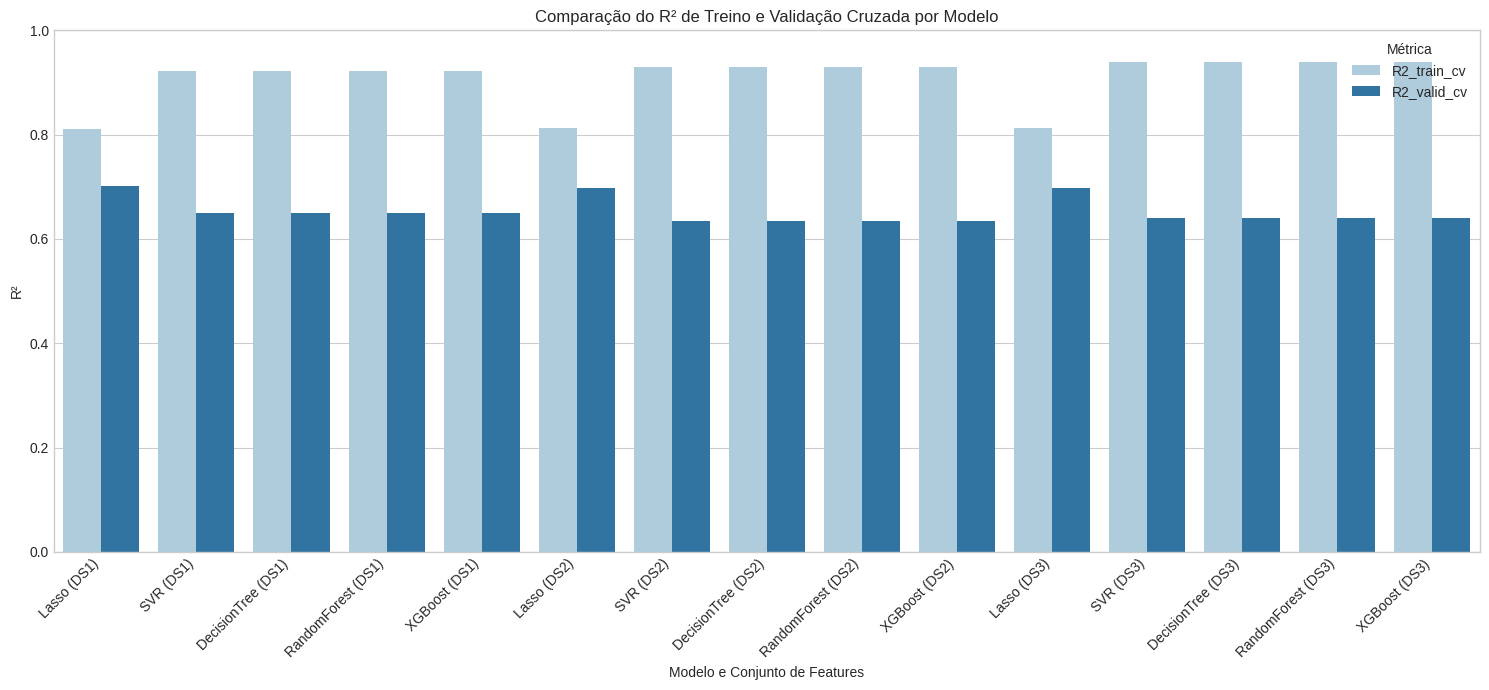

In [12]:
# Criando os gráficos de comparação
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Paired")

# Preparando os dados para plotagem
results_plot = results_validation_df.melt(id_vars=['model', 'feature_set'],
                                         value_vars=['R2_train_cv', 'R2_valid_cv', 'RMSE_train_cv', 'RMSE_valid'],
                                         var_name='metric',
                                         value_name='value')

# Criando a feature_set_name para o eixo X
results_plot['experiment'] = results_plot['model'] + ' (' + results_plot['feature_set'] + ')'

# --- Gráfico de Comparação de RMSE ---
plt.figure(figsize=(15, 7))
rmse_data = results_plot[results_plot['metric'].isin(['RMSE_train_cv', 'RMSE_valid'])]
sns.barplot(data=rmse_data, x='experiment', y='value', hue='metric')
plt.title('Comparação do RMSE de Treino e Validação Cruzada por Modelo')
plt.ylabel('RMSE')
plt.xlabel('Modelo e Conjunto de Features')
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=0)
plt.legend(title='Métrica')
plt.tight_layout()
plt.savefig('rmse_train_vs_valid.png')
plt.close()

# --- Gráfico de Comparação de R² ---
plt.figure(figsize=(15, 7))
r2_data = results_plot[results_plot['metric'].isin(['R2_train_cv', 'R2_valid_cv'])]
sns.barplot(data=r2_data, x='experiment', y='value', hue='metric')
plt.title('Comparação do R² de Treino e Validação Cruzada por Modelo')
plt.ylabel('R²')
plt.xlabel('Modelo e Conjunto de Features')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='Métrica')
plt.tight_layout()
plt.savefig('r2_train_vs_valid.png')
plt.show()